<a href="https://colab.research.google.com/github/karlriis/trajectory-forecasting/blob/main/Neural_network_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites to run:
- clone https://github.com/crowdbotp/OpenTraj into the current folder

In [ ]:
! git clone https://github.com/crowdbotp/OpenTraj.git

fatal: destination path 'OpenTraj' already exists and is not an empty directory.


In [ ]:
! pip install pykalman

In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj/') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

In [ ]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=4)

/content/OpenTraj/opentraj/toolkit/loaders/loader_edinburgh.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(file, sep="\n|=", header=None,index_col=None)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|██████████| 2342/2342 [06:10<00:00,  6.32it/s]


Warning! too big dt in [Edinburgh]
finish


In [ ]:
data = traj_dataset.data
NUM_OF_STEPS = 5
# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y

def generate_velocity_data(data, begin_idx, agent_id, num_steps=5):
    sample_vel_x = data["vel_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_vel_y = data["vel_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    
    test_vel_x = data["vel_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_vel_y = data["vel_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_vel_x, sample_vel_y, test_vel_x, test_vel_y

def plot_predictions(sample_x, sample_y, test_x, test_y, pred_x, pred_y):
    plt.axes().set_aspect('equal')
        
    plt.plot(np.append(sample_x, pred_x), np.append(sample_y, pred_y), label="fitted polynomial", color='r')
    plt.plot(np.append(sample_x, test_x), np.append(sample_y,test_y), label="actual data", color='b')

    plt.scatter(sample_x[0], sample_y[0], color='b')
    plt.scatter(sample_x[-1], sample_y[-1], color='gray')
    plt.scatter(pred_x[0], pred_y[0], color='r')

    # Comment out the following if you want to see all generated trajectories
    #for i in range(len(pred_x_list)):
    #    plt.plot(np.append(sample_x,pred_x_list[i]), np.append(sample_y,pred_y_list[i]), label="fitted polynomial")

    #plt.legend()
    plt.show()
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

## Input is t and t^2

### Tests with the architecture

In [ ]:
# https://stackoverflow.com/questions/44036971/multiple-outputs-in-keras

from keras.models import Model
from keras.layers import *    

inp = Input((2,))

x = Dense(64, activation='linear')(inp)

out1 = Dense(1, activation='linear')(x)    
out2 = Dense(1, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
trainInput = np.array([[1, 1], [2, 4], [3, 9], [4, 16], [5, 25]])

trainOutputX = np.array([0.5, 1.1, 1.7, 2.4, 3.0])
trainOutputY = np.array([0.5, 0.6, 0.8, 1.1, 1.3])

model.fit(trainInput,[trainOutputX, trainOutputY], epochs=500, batch_size=5)

Epoch 1/500
1/1 [==============================] - 0s 14ms/step - loss: 0.3148 - dense_5926_loss: 0.0654 - dense_5927_loss: 0.2494
Epoch 2/500
1/1 [==============================] - 0s 15ms/step - loss: 0.3120 - dense_5926_loss: 0.0647 - dense_5927_loss: 0.2474
Epoch 3/500
1/1 [==============================] - 0s 19ms/step - loss: 0.3092 - dense_5926_loss: 0.0639 - dense_5927_loss: 0.2453
Epoch 4/500
1/1 [==============================] - 0s 15ms/step - loss: 0.3065 - dense_5926_loss: 0.0632 - dense_5927_loss: 0.2433
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 0.3037 - dense_5926_loss: 0.0625 - dense_5927_loss: 0.2412
Epoch 6/500
1/1 [==============================] - 0s 20ms/step - loss: 0.3009 - dense_5926_loss: 0.0617 - dense_5927_loss: 0.2392
Epoch 7/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2981 - dense_5926_loss: 0.0610 - dense_5927_loss: 0.2371
Epoch 8/500
1/1 [==============================] - 0s 18ms/step - loss: 0.2954 - de

In [ ]:
#test_loss, test_acc = model.evaluate(testData, testOutput)
#print("Test Accuracy : ", test_acc)
continuation = np.array([[6, 36], [7, 49], [8,64], [9,81],[10,100]])
preds = model.predict(continuation)
print(preds[0])
print(preds[1])

train_preds = model.predict(trainInput)
#print(train_preds[0])
#print(train_preds[1])

#trainOutputX = np.array([0.5, 1.1, 1.7, 2.4, 3.0])
#trainOutputY = np.array([0.5, 0.6, 0.8, 1.1, 1.3])

[[4.0321765]
 [5.101599 ]
 [6.30356  ]
 [7.6380644]
 [9.105105 ]]
[[1.6898681]
 [2.0946302]
 [2.5532787]
 [3.065805 ]
 [3.6322124]]


### Actual experiment

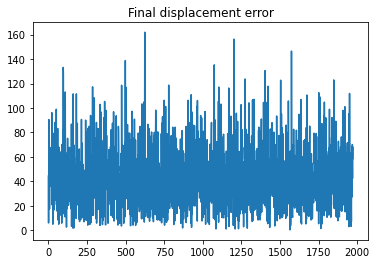

Average FDE:  42.511814


In [ ]:
def train_and_predict(sample_x, sample_y, test_x):

  inp = Input((2,))

  x = Dense(8, activation='relu')(inp)

  out1 = Dense(1)(x)    
  out2 = Dense(1)(x)

  model = Model(inputs=inp, outputs=[out1,out2])
  model.compile(optimizer = 'adam', loss = tf.keras.metrics.mean_squared_error)

  time_range_train = np.array([[x, x**2] for x in range(len(sample_x))])
  time_range_pred = np.array([[x, x**2] for x in range(len(sample_x), 2*len(sample_x))])

  model.fit(time_range_train,[np.array(sample_x), np.array(sample_y)], epochs=1, batch_size=5, verbose=0)
  pred_x, pred_y = model.predict(time_range_pred)
  return pred_x, pred_y

def nn_time_input(data, agent_id, step, num_of_trajectories=5, noise=0.05, plot_data=False):
    # Generate 'seen' and 'unseen' data
    sample_x, sample_y, test_x, test_y = generate_data(data, 0, agent_id, step)
    
    preds_x, preds_y = train_and_predict(sample_x, sample_y, test_x)
    
    if (plot_data):
        plot_predictions(sample_x, sample_y, test_x, test_y, preds_x, preds_y)
    
    # Error calculation
    
    FDE, MSE = calculate_error(preds_x, preds_y, test_x, test_y)
    return FDE, MSE

step = 5
all_FDE = []
for i in agent_ids:
    run_FDE, run_MSE = nn_time_input(data, agent_id=i, step=step)
    all_FDE.append(run_FDE)


plt.plot(all_FDE)
plt.title("Final displacement error")
plt.show()

print("Average FDE: ", np.mean(all_FDE))

In [ ]:
# Checking some plot examples
for i in agent_ids[:20]:
    run_rmse = nn_time_input(data, agent_id=i, step=NUM_OF_STEPS, plot_data=True)